In [29]:

from sqlalchemy import (create_engine, Table, Column, Integer, String, MetaData, inspect)
import pandas as pd
import pymysql.cursors
import matplotlib.pyplot as plt
import numpy as np
import operator
import random
import math
from sklearn.metrics import mean_squared_error as mse
%matplotlib inline
connection = pymysql.connect(host='localhost',
                             user='root',
                             password='',#put your password for mysql server here.
                             db='yelp_db',
                             charset='utf8mb4',
                             cursorclass=pymysql.cursors.DictCursor)

In [2]:
#extract business_id, user_id, rating stars and other relative information from the database.

pittsburgh_rate=pd.read_sql('''
select business.id as business_id,category.category, business.city,user.id as user_id,review.stars,review.useful from
business inner join review inner join user inner join category
on business.id=review.business_id
and user.id=review.user_id
and category.business_id=business.id
where business.city ="Pittsburgh"
and category="restaurants" order by user_id asc
''',connection)

In [3]:
#display the pittsburgh restaurant id along with user id and corresponding rating. 
pittsburgh_rate.head(10)

,business_id,category,city,user_id,stars,useful
0,mnI_n7A8sxgOSmtgI3wzQQ,Restaurants,Pittsburgh,--CH8yRGXhO2MmbF-4BWXg,5,0
1,TZpTyyGvQkKPnt59PVUGhg,Restaurants,Pittsburgh,--CH8yRGXhO2MmbF-4BWXg,5,0
2,X8AGCsJHw-GuTqkzy2J3cg,Restaurants,Pittsburgh,--cO5bedOWodnt8UgamQNA,5,0
3,b_XIKJ2nNzksuWhfMTEehQ,Restaurants,Pittsburgh,--EMqnd727rtC0G5Oc-Mrg,5,0
4,H-B_JoResY4PyXND1_DQfg,Restaurants,Pittsburgh,--EMqnd727rtC0G5Oc-Mrg,5,0
5,IBGrQ6YUywBp1Hqu9c1LZQ,Restaurants,Pittsburgh,--fFGOHU7mjZ670MkFJeFA,5,0
6,RA_Q__KAdk9rJqtAByUFjA,Restaurants,Pittsburgh,--j4xIyyr5ip-WCbNGzMkA,4,0
7,SvCjBtbN1cKElDKPTw9dOA,Restaurants,Pittsburgh,--mQ4S5h1tXzvE9VDYVwdQ,4,1
8,TKDL0wiztnEr_rMkX8ZomQ,Restaurants,Pittsburgh,--mQ4S5h1tXzvE9VDYVwdQ,5,0
9,0PtNw7RgF4JFcPyP-LqZ_Q,Restaurants,Pittsburgh,--OECAoqfSTBaZ3biOyzwA,5,0


In [4]:
#get number of users 
num_users = pittsburgh_rate.user_id.unique().shape[0]
#get number of unique restaurants
num_movies = pittsburgh_rate.business_id.unique().shape[0]
#initialize the utility matrix by filling zeros. 
utility = np.zeros((num_users, num_movies))

In [5]:
#get the list of users' id
user_id_list=pittsburgh_rate.user_id.unique().tolist()
#get the list of restaurants' id
restaurant_id_list=pittsburgh_rate.business_id.unique().tolist()

In [6]:
#def get_user_id_from_index(index):
#    return pittsburgh_rate.iloc[index].user_id

def get_index_from_user_id(id):
    return user_id_list.index(id)

def get_index_from_restaurant_id(id):
    return restaurant_id_list.index(id)


In [7]:
#get true utility matrix
for index,rating in pittsburgh_rate.iterrows():
    utility[get_index_from_user_id(rating.user_id),get_index_from_restaurant_id(rating.business_id)]=rating.stars

In [8]:
sparsity = float(len(utility.nonzero()[0]))
sparsity /= (utility.shape[0] * utility.shape[1])
sparsity *= 100
print('Sparsity: {:.2f}%'.format(sparsity))

Sparsity: 0.14%


In [9]:
pd.DataFrame(utility).head(10)

,0,1,2,3,4,5,6,7,8,9,...,2079,2080,2081,2082,2083,2084,2085,2086,2087,2088
0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
u=utility[:20000,]

In [11]:
pd.DataFrame(utility).shape

(38138, 2089)

In [12]:
def mse_utility(u1, u2):
    return mse(u1[u1.nonzero()].flatten(), u2[u2.nonzero()].flatten())



def sim_matrix(u, eps=1.0e-9):
    step1 = u.dot(u.T) + eps
    step2 = np.array([np.sqrt(np.diagonal(step1))])
    return (step1 / step2 / step2.T)

def sim_users(u):
    return sim_matrix(u)

def sim_items(u):
    return sim_matrix(u.T)

def top_k(arr, self_idx, k):
    i = np.argsort(-arr)[:k+1]
    return {index:arr[index] for index in i[1:]}

def rec_via_users(m_utility, m_sim_users, user_idx, item_idx, k):
    userslist = top_k(m_sim_users[user_idx], user_idx, k)
    numerator, denominator= [], []
    for k, v in userslist.items():
        if m_utility[k,item_idx] != 0:
            numerator.append(m_utility[k,item_idx]*v)
            denominator.append(v)
        else:
            denominator.append(0)
    if(sum(denominator) != 0):
        return sum(numerator) / sum(denominator)
    else:
        return 0

In [13]:
sim_u1 = sim_users(u)
print(sim_u1)

[[  1.00000000e+00   2.82842712e-11   2.00000000e-11 ...,   3.16227766e-11
    2.82842712e-11   2.82842712e-11]
 [  2.82842712e-11   1.00000000e+00   2.82842712e-11 ...,   4.47213595e-11
    4.00000000e-11   4.00000000e-11]
 [  2.00000000e-11   2.82842712e-11   1.00000000e+00 ...,   3.16227766e-11
    2.82842712e-11   2.82842712e-11]
 ..., 
 [  3.16227766e-11   4.47213595e-11   3.16227766e-11 ...,   1.00000000e+00
    4.47213595e-11   4.47213595e-11]
 [  2.82842712e-11   4.00000000e-11   2.82842712e-11 ...,   4.47213595e-11
    1.00000000e+00   4.00000000e-11]
 [  2.82842712e-11   4.00000000e-11   2.82842712e-11 ...,   4.47213595e-11
    4.00000000e-11   1.00000000e+00]]


In [14]:
random.seed(12345)
def recs_via_users(m_utility, m_sim_users, k, test_n):
    #randomly pick up n test users from the whole users
    test = random.sample(range(m_sim_users.shape[0]), test_n)
    true = []
    pred = []
    for user_idx in test:
        for item_idx in range(m_utility.shape[1]):
            if m_utility[user_idx][item_idx] != 0:
                true.append(m_utility[user_idx][item_idx])
                p=round(rec_via_users(m_utility, m_sim_users, user_idx, item_idx, k))
                if p != 0:    
                    pred.append(p)
                else:
                    pred.append(1.0e-9)
    return mse_utility(np.array([true], dtype=np.float64), np.array([pred], dtype=np.float64))

In [15]:
num_k_userbased = []
mses = []
for i in range(200):
    num_k_userbased.append(i+1)
    mses.append(recs_via_users(u, sim_u1, i+1, 300))
    print("{}/200".format(i+1), mses[-1])

1/200 7.6486761674
2/200 8.09659714206
3/200 6.6273486399
4/200 5.83961248371
5/200 5.04479578139
6/200 5.40981594825
7/200 4.45727847891
8/200 5.77995109757
9/200 4.59056603558
10/200 4.83671399362
11/200 4.15999999813
12/200 4.19640387082
13/200 4.59369369165
14/200 4.22933643573
15/200 4.11264181345
16/200 3.70170827697
17/200 2.75205479346
18/200 3.94093406427
19/200 3.81945945778
20/200 4.01271186267
21/200 3.7740324577
22/200 3.99999999836
23/200 3.51408450561
24/200 3.24548736327
25/200 3.57336342959
26/200 3.94665012234
27/200 3.06589147165
28/200 3.38796680352
29/200 3.04074402009
30/200 3.71445929369
31/200 3.06605019683
32/200 3.43842887332
33/200 3.96800825424
34/200 3.34725848428
35/200 3.19288888756
36/200 3.00415973255
37/200 3.20187304766
38/200 2.71395076109
39/200 3.105147863
40/200 3.25735992285
41/200 3.05972045625
42/200 3.49156626367
43/200 2.74267782326
44/200 3.60454002243
45/200 2.89836448487
46/200 2.97481108207
47/200 2.62973351928
48/200 3.41482444603
49/200

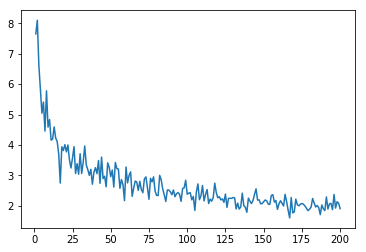

In [16]:
plt.plot(num_k_userbased, mses)
plt.savefig('mse_k_user_based.pdf', format='pdf', dpi=1000)

In [17]:
def rec_via_items(m_utility, m_sim_items, user_idx, item_idx, k):
    items_list = top_k(m_sim_items[item_idx], item_idx, k)
    numerator, denominator= [], []
    for key, v in items_list.items():
        if m_utility[user_idx,key] != 0:
            numerator.append(m_utility[user_idx,key]*v)
            denominator.append(v)
        else:
            denominator.append(0)
    if(sum(denominator) != 0):
        return sum(numerator)/sum(denominator)
    else:
        return 0
    
random.seed(12345)
def recs_via_items(m_utility, m_sim_items, k, test_n):
    test = random.sample(range(m_sim_items.shape[0]), test_n)
    true = []
    pred = []
    for item_idx in test:
        for user_idx in range(m_utility.shape[0]):
            if m_utility[user_idx][item_idx] != 0:
                true.append(m_utility[user_idx][item_idx])
                
                p = round(rec_via_items(m_utility, m_sim_items, user_idx, item_idx, k))
                if p != 0:    
                    pred.append(p)
                else:
                    pred.append(1.0e-9)
                        

    return mse_utility(np.array([true], dtype=np.float64), np.array([pred], dtype=np.float64))
    
sim_i1 = sim_items(u)



In [18]:
num_k_itembased = []
mses2 = []
for i in range(200):
    num_k_itembased.append(i+1)
    mses2.append(recs_via_users(u, sim_i1, i+1,300))
    print("{}/200".format(i+1), mses2[-1])

1/200 14.841567284
2/200 14.5111561794
3/200 15.1874334325
4/200 14.92151898
5/200 15.3508946249
6/200 14.7946799596
7/200 14.7328453725
8/200 14.7096774123
9/200 14.7630922623
10/200 15.2674297534
11/200 14.2103533209
12/200 14.350282479
13/200 14.380319142
14/200 14.3104238191
15/200 14.5458768804
16/200 14.6712898683
17/200 13.2800361272
18/200 14.0704545387
19/200 13.8201438783
20/200 13.9205297948
21/200 13.2308340289
22/200 13.4513761403
23/200 13.8188638733
24/200 13.427821516
25/200 13.9344660128
26/200 13.2999999936
27/200 13.4542651528
28/200 12.9347614348
29/200 13.4934210462
30/200 13.1773666966
31/200 13.4228070111
32/200 12.6012544742
33/200 13.3595608353
34/200 12.9905437289
35/200 13.6628959213
36/200 13.5845136858
37/200 13.398773
38/200 13.2502979676
39/200 12.4555837505
40/200 13.4096256622
41/200 13.4624846187
42/200 12.7791563216
43/200 13.2385026677
44/200 13.234096686
45/200 13.194103188
46/200 12.6609257206
47/200 12.9308437009
48/200 12.6749999941
49/200 11.805

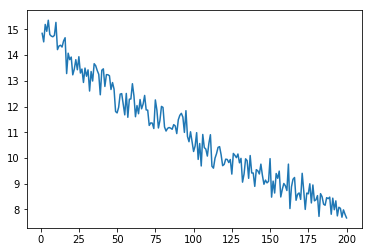

In [19]:

plt.plot(num_k_itembased, mses2)
plt.savefig('mse_k_item_based.pdf', format='pdf', dpi=1000)
plt.show()

#legend = plt.legend([labelsKm[i] for i in range(len(labelsKm))],bbox_to_anchor=(1.05, 1),
#                    loc=2, borderaxespad=0.,fontsize=15)

#plt.savefig('mse of item based rec sys.pdf', bbox_extra_artists=(legend,), bbox_inches='tight')

In [21]:
pittsburgh_rate.useful.value_counts()
score_list=pittsburgh_rate.useful.tolist()
score_list=[math.log(i+2,2)for i in score_list]

In [22]:
pittsburgh_rate['score'] = pd.Series(score_list, index=pittsburgh_rate.index)

In [23]:
scores = np.zeros((num_users, num_movies))
for index,rating in pittsburgh_rate.iterrows():
    scores[get_index_from_user_id(rating.user_id),get_index_from_restaurant_id(rating.business_id)]=rating.score
    

In [24]:
def rec_via_users_scored(m_utility,m_score, m_sim_users, user_idx, item_idx, k):
    userslist = top_k(m_sim_users[user_idx], user_idx, k)
    numerator, denominator= [], []
    for k, v in userslist.items():
        if m_utility[k,item_idx] != 0:
            numerator.append(m_utility[k,item_idx]*v*m_score[k,item_idx])
            denominator.append(v*m_score[k,item_idx])
        else:
            denominator.append(0)
    if(sum(denominator) != 0):
        return sum(numerator) / sum(denominator)
    else:
        return 0
    
def recs_via_users_scored(m_utility, m_score, m_sim_users, k, test_n):
    #randomly pick up n test users from the whole users
    test = random.sample(range(m_sim_users.shape[0]), test_n)
    true = []
    pred = []
    for user_idx in test:
        for item_idx in range(m_utility.shape[1]):
            if m_utility[user_idx][item_idx] != 0:
                true.append(m_utility[user_idx][item_idx])
                
                p = round(rec_via_users_scored(m_utility,m_score, m_sim_users, user_idx, item_idx, k))
                if p != 0:    
                    pred.append(p)
                else:
                    pred.append(1.0e-9)
                        

    return mse_utility(np.array([true], dtype=np.float64), np.array([pred], dtype=np.float64))/2

In [25]:
num_userbased_scored = []
mses3 = []
for i in range(200):
    num_userbased_scored.append(i+1)
    mses3.append(recs_via_users_scored(u, scores, sim_u1, i+1, 300))
    print("{}/200".format(i+1), mses3[-1])


1/200 4.09437499803
2/200 4.13835770331
3/200 3.54727030458
4/200 2.53846153726
5/200 2.95707375912
6/200 2.24373258938
7/200 2.7288732381
8/200 2.38278388162
9/200 2.14760147494
10/200 2.07870370271
11/200 2.34803921457
12/200 1.90161104639
13/200 2.21245828596
14/200 2.246031745
15/200 2.15010799042
16/200 1.93576965587
17/200 1.94726027318
18/200 1.94319682877
19/200 1.89005235513
20/200 1.84913043399
21/200 2.33722163201
22/200 1.7574385504
23/200 2.18546365819
24/200 2.09153122238
25/200 1.7997685177
26/200 1.79013641057
27/200 1.92671983964
28/200 1.46797004936
29/200 1.80055865845
30/200 1.77790973793
31/200 1.82075471618
32/200 1.74999999927
33/200 1.82235294046
34/200 1.46646341403
35/200 1.64359177146
36/200 1.4784883716
37/200 1.63574879166
38/200 1.80055248549
39/200 1.48395966945
40/200 1.6683870961
41/200 1.51834319468
42/200 1.65575303959
43/200 1.67940199268
44/200 1.51757631762
45/200 1.38154981498
46/200 1.67438563261
47/200 1.42449841551
48/200 1.31344696925
49/200 1

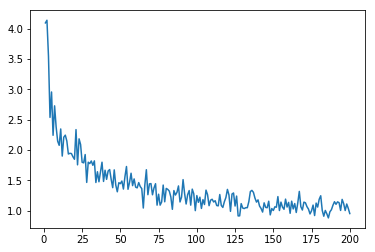

In [26]:
plt.plot(num_userbased_scored, mses3)
plt.savefig('mse_k_user_based_scored.pdf', format='pdf', dpi=1000)
plt.show()

In [30]:
#evaluate rec_via_user_scored, top k=100, number of recommend=5
def Recs_via_users_scored(user_id,m_utility=u, m_score=scores, m_sim_users=sim_u1, k=100):
    #randomly pick up n test users from the whole users
    user_idx=user_id_list.index(user_id)
    pred=[]
    for item_idx in range(m_utility.shape[1]):
        p = rec_via_users_scored(m_utility,m_score, m_sim_users, user_idx, item_idx, k)
        if p != 0:    
            pred.append((p,restaurant_id_list[item_idx]))
        else:
            pred.append((1.0e-9,restaurant_id_list[item_idx]))
    return pred


def recommand_given_userid(User_id):
    restaurants_ids=[]
    Rec_item_list=Recs_via_users_scored(user_id=User_id)
    Rec_item_list.sort(key=operator.itemgetter(0),reverse=True)
    restaurants_ids=Rec_item_list[:5]
    for i in range(len(restaurants_ids)):
        restaurants_ids[i]=restaurants_ids[i][1]
    return restaurants_ids


In [31]:
restaurant_ids=recommand_given_userid(User_id=user_id_list[199])

In [32]:
restaurant_recommended=[]
for id in restaurant_ids:
    restaurant_name=pd.read_sql('''select business.name from business where business.id='''+'\''+id+'\'',connection).iloc[0]['name']
    restaurant_recommended.append(restaurant_name)
                                

In [33]:
for r in restaurant_recommended:
    print(r)

Meat & Potatoes
Burgatory
Maiku Sushi
The Green Mango
Chaya Japanese Cuisine
